<a href="https://colab.research.google.com/github/sathvik3103/GenAI/blob/main/Langgraph_Chatbot_%2B_Tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

In [2]:
!pip install typing

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

In [4]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun
from langchain_community.tools import WikipediaQueryRun

In [5]:
!pip install arxiv
arxiv_wrapper = ArxivAPIWrapper(top_k_results=3, doc_content_chars_max=500)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

In [6]:
!pip install wikipedia
wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=500)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

In [7]:
tools = [arxiv_tool,wikipedia_tool]

In [8]:
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages: Annotated[list, add_messages]
    tools: list

In [9]:
from langgraph.graph import StateGraph, START, END
graph_builder = StateGraph(State)

In [10]:
from langchain_groq import ChatGroq
llm = ChatGroq(groq_api_key="GROQ_API_KEY",model_name="Gemma2-9b-It")

In [11]:
llm_with_tools = llm.bind(tools=tools)

In [12]:
def chatbot(state:State):
  return{"messages":llm_with_tools.invoke(state["messages"])}

In [13]:
from langgraph.prebuilt import ToolNode, tools_condition

In [14]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tool_executor", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tool_executor", "chatbot")
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot",END)

In [15]:
graph = graph_builder.compile()

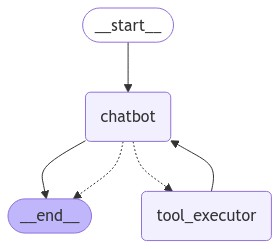

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [32]:
user_input="what is RLHF"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

In [33]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF


TypeError: Object of type type is not JSON serializable